# experiments on image transformation

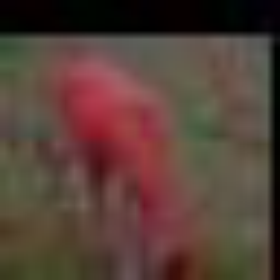

In [636]:
# import requierd libraries
import torch
from PIL import Image
import torchvision.transforms as transforms

# Read the input image
img = Image.open('train/113.jpg')
transform = transforms.Resize(280)
transform(img)


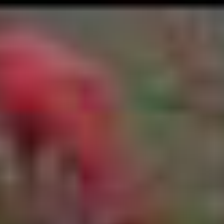

In [656]:

# define the transform to apply random affine
transform = transforms.Compose([
                          transforms.RandomResizedCrop(280,scale=(0.8,1.2)),
                          transforms.CenterCrop(224),
                          transforms.RandomHorizontalFlip()])

# apply the above defined transform on the input image
transform(img)

# display the transformed image
#img

# prepare

In [1]:
import numpy as np
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
import pandas as pd
from sklearn.model_selection import train_test_split
import PIL
import os
from IPython.display import Image 
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

In [2]:
data = pd.read_csv("train_labels.csv")

In [3]:
train_df, val_df = train_test_split(data, test_size=0.2, random_state=1,stratify=data["label"])

In [4]:
train_df

,id,label
38897,38897,7
24035,24035,2
27492,27492,9
5994,5994,4
14389,14389,6
...,...,...
46328,46328,5
14888,14888,9
45597,45597,0
10841,10841,1


In [5]:
train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)

In [6]:
train_df

,id,label
0,38897,7
1,24035,2
2,27492,9
3,5994,4
4,14389,6
...,...,...
39995,46328,5
39996,14888,9
39997,45597,0
39998,10841,1


In [7]:
data_transformers = {"train": transforms.Compose([
                                       transforms.RandomResizedCrop(64),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485,0.456,0.406],
                                             [0.229,0.224,0.225])]),
            "val":transforms.Compose([transforms.Resize(68),
                          transforms.CenterCrop(64),
                          transforms.ToTensor(),
                          transforms.Normalize([0.485,0.456,0.406],
                                     [0.229,0.224,0.225])])}

In [8]:
data_transformers2 = {"train": transforms.Compose([transforms.RandomResizedCrop(280,scale=(0.8,1.2)),
                                       transforms.CenterCrop(224),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485,0.456,0.406],
                                             [0.229,0.224,0.225])]),
            "val":transforms.Compose([transforms.Resize(256),
                          transforms.CenterCrop(224),
                          transforms.ToTensor(),
                          transforms.Normalize([0.485,0.456,0.406],
                                     [0.229,0.224,0.225])])}

In [9]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, csv_df, images_folder, transform=None):
        self.df = csv_df
        self.image_folder = images_folder
        self.transform = transform
    
    def __len__(self):
        return len(self.df)
    def __getitem__(self, index):
        filename = self.df["id"][index]
        label = self.df["label"][index]
        image = PIL.Image.open(self.image_folder+str(filename)+".jpg")
        if self.transform is not None:
            image = self.transform(image)
        return image, label

In [10]:
train_data = CustomDataset(train_df, "./train/",transform=data_transformers["train"])
val_data = CustomDataset(val_df, "./train/", transform=data_transformers["val"])

In [11]:
train_loader = DataLoader(train_data, batch_size=128,shuffle=True)
val_loader = DataLoader(val_data, batch_size =128, shuffle=True)

In [12]:
def accuracy_test(model,dataloader,epoch):
    correct = 0
    total = 0
    model.cuda() 
    model.eval()
    total_loss = 0
    with torch.no_grad(): 
        for data in dataloader:
           
            images,labels = data
            images,labels = images.to('cuda'),labels.to('cuda')
            

            outputs = model(images)
            _, predicted = torch.max(outputs.data,1) 
            loss = criterion(outputs,labels)
            total_loss += loss.item()
            
            
            total += labels.size(0)
            
            correct += (predicted == labels).sum().item()
            
    print("The validation loss is %.4f" % (total_loss/len(dataloader)))
    print('The valudation accuracy is {:.4f}\n'.format(correct/total))

from tqdm.auto import tqdm
import math

def train(model,trainloader,epochs,print_every,criterion,optimizer,device,name):
    num_training_steps = epochs * (len(trainloader))
    progress_bar = tqdm(range(num_training_steps))
    epochs = epochs 
    print_every = math.floor(num_training_steps/print_every)
    steps = 0
    model.to(device)
    model.train()
    total = 0
    correct = 0

    name = name
    running_loss = 0
    for e in range(epochs):
        #running_loss = 0
        for ii , (inputs,labels) in enumerate(trainloader):
            steps += 1
            inputs,labels = inputs.to(device),labels.to(device)
            optimizer.zero_grad() 
            
            # 前馈及反馈
            outputs = model(inputs) 
            
            _, predicted = torch.max(outputs.data,1) 
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            #print(labels.size(),outputs.size())
            loss = criterion(outputs,labels) 
            loss.backward() 
            optimizer.step() 
            
            running_loss += loss.item() # maybe accumulate loss for steps?
            progress_bar.update(1)
            
            if steps % print_every == 0:
                #test the accuracy
                print('EPOCHS : {}/{}'.format(e+1,epochs),
                      'Loss : {:.6f}'.format(running_loss/print_every)) # this is a simgle loss divided by print_every
                print('The training accuracy is {:.4f}'.format(correct/total))
                running_loss=0
                accuracy_test(model,val_loader,e)
                #print("training accuracy: \n")
                #accuracy_test(model,trainloader)
    torch.save(model.state_dict(), "Weights/myCNN_experiment1_cont_{}.pkl".format(name))

In [13]:
criterion = nn.CrossEntropyLoss().cuda()

# Base model - train 60%/1.11 - val 68%/0.90

In [30]:
# base model: conv/pool + conv/conv/pool + conv/conv/pool + conv/conv/conv/pool + 1 dense
class CNN_base(nn.Module):
    def __init__(self):
        super(CNN_base,self).__init__()
        self.convlayers = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1,padding=1),
            #nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2,2),
            #nn.Dropout2d(p=0.1),
            
            nn.Conv2d(64, 128, kernel_size=3,stride=1,padding=1),
            #nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3,stride=1,padding=1),
            #nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2,2),
            #nn.Dropout2d(p=0.2),
            
            nn.Conv2d(128,256,kernel_size=3,stride=1,padding=1),
            #nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256,256,kernel_size=3,stride=1,padding=1),
            nn.ReLU(inplace=True),
            #nn.Conv2d(256,256,kernel_size=3,stride=1,padding=1),
            #nn.BatchNorm2d(256),
            #nn.ReLU(inplace=True),
            nn.MaxPool2d(2,2),
            #nn.Dropout2d(p=0.3),
            
            nn.Conv2d(256,512,kernel_size=3,stride=1,padding=1),
            #nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512,512,kernel_size=3,stride=1,padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512,512,kernel_size=3,stride=1,padding=1),
            #nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2,2),
            #nn.Dropout2d(p=0.5),
            
            
            
        )
        #self.finalconv = nn.AdaptiveAvgPool2d(output_size=(7,7))
        self.finaldense = nn.Sequential(
            nn.Linear(8192,10,True),
            #nn.ReLU(inplace=True),
            #nn.Dropout(0.5),
           # nn.Linear(2048,1024,True),
            #nn.ReLU(inplace=True),
            #nn.Dropout(0.5),
            #nn.Linear(1024,10,True)
        )
    
    def forward(self,x):
        x = self.convlayers(x)
        #x = self.finalconv(x)
        x = torch.flatten(x,1)
        x = self.finaldense(x)
        return x

In [31]:
criterion = nn.CrossEntropyLoss().cuda()

In [32]:
myCNN_base = CNN_base()
myCNN_base.cuda()

CNN_base(
  (convlayers): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (13): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14): ReLU(inplace=True)
    (15): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
 

In [33]:
optimizer = optim.AdamW(myCNN_base.parameters(),lr=5e-5)
train(myCNN_base,train_loader, 12,80 ,criterion,optimizer,'cuda')

  0%|          | 0/3756 [00:00<?, ?it/s]

EPOCHS : 1/12 Loss : 2.244158
The training accuracy is 0.1578
The validation loss is 2.0855
The valudation accuracy is 0.2429

EPOCHS : 1/12 Loss : 2.068363
The training accuracy is 0.1972
The validation loss is 1.9672
The valudation accuracy is 0.2888

EPOCHS : 1/12 Loss : 1.971949
The training accuracy is 0.2278
The validation loss is 1.8683
The valudation accuracy is 0.3358

EPOCHS : 1/12 Loss : 1.910037
The training accuracy is 0.2472
The validation loss is 1.8002
The valudation accuracy is 0.3653

EPOCHS : 1/12 Loss : 1.841797
The training accuracy is 0.2636
The validation loss is 1.7199
The valudation accuracy is 0.3907

EPOCHS : 1/12 Loss : 1.788809
The training accuracy is 0.2781
The validation loss is 1.6700
The valudation accuracy is 0.3988

EPOCHS : 2/12 Loss : 1.763290
The training accuracy is 0.2898
The validation loss is 1.6854
The valudation accuracy is 0.3972

EPOCHS : 2/12 Loss : 1.745563
The training accuracy is 0.2997
The validation loss is 1.6158
The valudation accu

The validation loss is 1.1094
The valudation accuracy is 0.6143

EPOCHS : 10/12 Loss : 1.309981
The training accuracy is 0.4594
The validation loss is 1.0807
The valudation accuracy is 0.6168

EPOCHS : 10/12 Loss : 1.290448
The training accuracy is 0.4607
The validation loss is 1.0692
The valudation accuracy is 0.6328

EPOCHS : 10/12 Loss : 1.259260
The training accuracy is 0.4621
The validation loss is 1.0615
The valudation accuracy is 0.6365

EPOCHS : 11/12 Loss : 1.272270
The training accuracy is 0.4634
The validation loss is 1.1017
The valudation accuracy is 0.6094

EPOCHS : 11/12 Loss : 1.283450
The training accuracy is 0.4648
The validation loss is 1.0775
The valudation accuracy is 0.6191

EPOCHS : 11/12 Loss : 1.247590
The training accuracy is 0.4661
The validation loss is 1.0485
The valudation accuracy is 0.6354

EPOCHS : 11/12 Loss : 1.256484
The training accuracy is 0.4674
The validation loss is 1.0223
The valudation accuracy is 0.6430

EPOCHS : 11/12 Loss : 1.250369
The trai

In [35]:
optimizer = optim.AdamW(myCNN_base.parameters(),lr=1e-6)
train(myCNN_base,train_loader, 12, 40 ,criterion,optimizer,'cuda',"-2")

  0%|          | 0/3756 [00:00<?, ?it/s]

EPOCHS : 1/12 Loss : 1.166527
The training accuracy is 0.5865
The validation loss is 0.9480
The valudation accuracy is 0.6719

EPOCHS : 1/12 Loss : 1.161292
The training accuracy is 0.5916
The validation loss is 0.9354
The valudation accuracy is 0.6726

EPOCHS : 1/12 Loss : 1.171471
The training accuracy is 0.5913
The validation loss is 0.9313
The valudation accuracy is 0.6756

EPOCHS : 2/12 Loss : 1.154161
The training accuracy is 0.5926
The validation loss is 0.9294
The valudation accuracy is 0.6742

EPOCHS : 2/12 Loss : 1.160431
The training accuracy is 0.5922
The validation loss is 0.9284
The valudation accuracy is 0.6748

EPOCHS : 2/12 Loss : 1.159843
The training accuracy is 0.5918
The validation loss is 0.9301
The valudation accuracy is 0.6758

EPOCHS : 3/12 Loss : 1.144204
The training accuracy is 0.5925
The validation loss is 0.9292
The valudation accuracy is 0.6754

EPOCHS : 3/12 Loss : 1.152356
The training accuracy is 0.5928
The validation loss is 0.9245
The valudation accu

## Base-model - add batchnorm #1 - traing 66%/0.92 - val 76%/0.66 
Better

In [36]:
# base model: conv/pool + conv/conv/pool + conv/conv/pool + conv/conv/conv/pool + 1 dense
# add batchnorm after each conv layer for the first three layers
class CNN_base(nn.Module):
    def __init__(self):
        super(CNN_base,self).__init__()
        self.convlayers = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1,padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2,2),
            #nn.Dropout2d(p=0.1),
            
            nn.Conv2d(64, 128, kernel_size=3,stride=1,padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3,stride=1,padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2,2),
            #nn.Dropout2d(p=0.2),
            
            nn.Conv2d(128,256,kernel_size=3,stride=1,padding=1),
            #nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256,256,kernel_size=3,stride=1,padding=1),
            nn.ReLU(inplace=True),
            #nn.Conv2d(256,256,kernel_size=3,stride=1,padding=1),
            #nn.BatchNorm2d(256),
            #nn.ReLU(inplace=True),
            nn.MaxPool2d(2,2),
            #nn.Dropout2d(p=0.3),
            
            nn.Conv2d(256,512,kernel_size=3,stride=1,padding=1),
            #nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512,512,kernel_size=3,stride=1,padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512,512,kernel_size=3,stride=1,padding=1),
            #nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2,2),
            #nn.Dropout2d(p=0.5),
            
            
            
        )
        #self.finalconv = nn.AdaptiveAvgPool2d(output_size=(7,7))
        self.finaldense = nn.Sequential(
            nn.Linear(8192,10,True),
            #nn.ReLU(inplace=True),
            #nn.Dropout(0.5),
           # nn.Linear(2048,1024,True),
            #nn.ReLU(inplace=True),
            #nn.Dropout(0.5),
            #nn.Linear(1024,10,True)
        )
    
    def forward(self,x):
        x = self.convlayers(x)
        #x = self.finalconv(x)
        x = torch.flatten(x,1)
        x = self.finaldense(x)
        return x

In [38]:
myCNN_base1 = CNN_base()
myCNN_base1.cuda()

CNN_base(
  (convlayers): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): ReLU(inplace=True)
    (13): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14): ReLU(inplace=True)

In [41]:
optimizer = optim.AdamW(myCNN_base1.parameters(),lr=5e-5)
train(myCNN_base1,train_loader, 12,40 ,criterion,optimizer,'cuda',"1")

  0%|          | 0/3756 [00:00<?, ?it/s]

EPOCHS : 1/12 Loss : 1.987207
The training accuracy is 0.2597
The validation loss is 1.6839
The valudation accuracy is 0.3803

EPOCHS : 1/12 Loss : 1.738310
The training accuracy is 0.3162
The validation loss is 1.6305
The valudation accuracy is 0.4136

EPOCHS : 1/12 Loss : 1.680882
The training accuracy is 0.3441
The validation loss is 1.5351
The valudation accuracy is 0.4606

EPOCHS : 2/12 Loss : 1.615394
The training accuracy is 0.3630
The validation loss is 1.4689
The valudation accuracy is 0.4681

EPOCHS : 2/12 Loss : 1.588250
The training accuracy is 0.3774
The validation loss is 1.4589
The valudation accuracy is 0.4724

EPOCHS : 2/12 Loss : 1.558680
The training accuracy is 0.3885
The validation loss is 1.3964
The valudation accuracy is 0.4936

EPOCHS : 3/12 Loss : 1.531039
The training accuracy is 0.3976
The validation loss is 1.3892
The valudation accuracy is 0.5107

EPOCHS : 3/12 Loss : 1.498246
The training accuracy is 0.4063
The validation loss is 1.3095
The valudation accu

In [42]:
optimizer = optim.AdamW(myCNN_base1.parameters(),lr=1e-6)
train(myCNN_base1,train_loader, 12,40 ,criterion,optimizer,'cuda',"2")

  0%|          | 0/3756 [00:00<?, ?it/s]

EPOCHS : 1/12 Loss : 1.253340
The training accuracy is 0.5839
The validation loss is 0.8251
The valudation accuracy is 0.7117

EPOCHS : 1/12 Loss : 1.083941
The training accuracy is 0.6033
The validation loss is 0.7802
The valudation accuracy is 0.7277

EPOCHS : 1/12 Loss : 1.047332
The training accuracy is 0.6144
The validation loss is 0.7548
The valudation accuracy is 0.7364

EPOCHS : 2/12 Loss : 1.029062
The training accuracy is 0.6207
The validation loss is 0.7419
The valudation accuracy is 0.7391

EPOCHS : 2/12 Loss : 1.013022
The training accuracy is 0.6256
The validation loss is 0.7345
The valudation accuracy is 0.7434

EPOCHS : 2/12 Loss : 0.988714
The training accuracy is 0.6306
The validation loss is 0.7258
The valudation accuracy is 0.7483

EPOCHS : 3/12 Loss : 0.995477
The training accuracy is 0.6333
The validation loss is 0.7194
The valudation accuracy is 0.7487

EPOCHS : 3/12 Loss : 0.987098
The training accuracy is 0.6367
The validation loss is 0.7110
The valudation accu

In [43]:
optimizer = optim.AdamW(myCNN_base1.parameters(),lr=5e-7)
train(myCNN_base1,train_loader, 12,40 ,criterion,optimizer,'cuda',"3")

  0%|          | 0/3756 [00:00<?, ?it/s]

EPOCHS : 1/12 Loss : 1.049361
The training accuracy is 0.6368
The validation loss is 0.7043
The valudation accuracy is 0.7479

EPOCHS : 1/12 Loss : 0.976365
The training accuracy is 0.6482
The validation loss is 0.6954
The valudation accuracy is 0.7511

EPOCHS : 1/12 Loss : 0.969442
The training accuracy is 0.6513
The validation loss is 0.6849
The valudation accuracy is 0.7552

EPOCHS : 2/12 Loss : 0.943969
The training accuracy is 0.6562
The validation loss is 0.6847
The valudation accuracy is 0.7572

EPOCHS : 2/12 Loss : 0.962423
The training accuracy is 0.6574
The validation loss is 0.6832
The valudation accuracy is 0.7579

EPOCHS : 2/12 Loss : 0.942510
The training accuracy is 0.6597
The validation loss is 0.6776
The valudation accuracy is 0.7607

EPOCHS : 3/12 Loss : 0.955656
The training accuracy is 0.6611
The validation loss is 0.6751
The valudation accuracy is 0.7612

EPOCHS : 3/12 Loss : 0.956258
The training accuracy is 0.6612
The validation loss is 0.6752
The valudation accu

## Base-model - Batchnorm #2 - train 71%/0.80 - val 83%/0.53
Better

In [44]:
# base model: conv/pool + conv/conv/pool + conv/conv/pool + conv/conv/conv/pool + 1 dense
# add batchnorm after each conv layer for every conv layer
class CNN_base(nn.Module):
    def __init__(self):
        super(CNN_base,self).__init__()
        self.convlayers = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1,padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2,2),
            #nn.Dropout2d(p=0.1),
            
            nn.Conv2d(64, 128, kernel_size=3,stride=1,padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3,stride=1,padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2,2),
            #nn.Dropout2d(p=0.2),
            
            nn.Conv2d(128,256,kernel_size=3,stride=1,padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256,256,kernel_size=3,stride=1,padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            #nn.Conv2d(256,256,kernel_size=3,stride=1,padding=1),
            #nn.BatchNorm2d(256),
            #nn.ReLU(inplace=True),
            nn.MaxPool2d(2,2),
            #nn.Dropout2d(p=0.3),
            
            nn.Conv2d(256,512,kernel_size=3,stride=1,padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512,512,kernel_size=3,stride=1,padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512,512,kernel_size=3,stride=1,padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2,2),
            #nn.Dropout2d(p=0.5),
            
            
            
        )
        #self.finalconv = nn.AdaptiveAvgPool2d(output_size=(7,7))
        self.finaldense = nn.Sequential(
            nn.Linear(8192,10,True),
            #nn.ReLU(inplace=True),
            #nn.Dropout(0.5),
           # nn.Linear(2048,1024,True),
            #nn.ReLU(inplace=True),
            #nn.Dropout(0.5),
            #nn.Linear(1024,10,True)
        )
    
    def forward(self,x):
        x = self.convlayers(x)
        #x = self.finalconv(x)
        x = torch.flatten(x,1)
        x = self.finaldense(x)
        return x

In [45]:
myCNN_base2 = CNN_base()
myCNN_base2.cuda()

CNN_base(
  (convlayers): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU(inplace=True)
    (14): Conv2

In [47]:
optimizer = optim.AdamW(myCNN_base2.parameters(),lr=5e-5)
train(myCNN_base2,train_loader, 12,40 ,criterion,optimizer,'cuda',"1")

  0%|          | 0/3756 [00:00<?, ?it/s]

EPOCHS : 1/12 Loss : 1.750458
The training accuracy is 0.3695
The validation loss is 1.5327
The valudation accuracy is 0.4552

EPOCHS : 1/12 Loss : 1.651133
The training accuracy is 0.3900
The validation loss is 1.4146
The valudation accuracy is 0.5069

EPOCHS : 1/12 Loss : 1.549947
The training accuracy is 0.4091
The validation loss is 1.3310
The valudation accuracy is 0.5360

EPOCHS : 2/12 Loss : 1.495199
The training accuracy is 0.4234
The validation loss is 1.2953
The valudation accuracy is 0.5460

EPOCHS : 2/12 Loss : 1.447194
The training accuracy is 0.4369
The validation loss is 1.2475
The valudation accuracy is 0.5579

EPOCHS : 2/12 Loss : 1.420691
The training accuracy is 0.4471
The validation loss is 1.1947
The valudation accuracy is 0.5759

EPOCHS : 3/12 Loss : 1.380977
The training accuracy is 0.4565
The validation loss is 1.1618
The valudation accuracy is 0.5909

EPOCHS : 3/12 Loss : 1.364944
The training accuracy is 0.4635
The validation loss is 1.1443
The valudation accu

In [48]:
optimizer = optim.AdamW(myCNN_base2.parameters(),lr=1e-6)
train(myCNN_base2,train_loader, 12,40 ,criterion,optimizer,'cuda',"2")

  0%|          | 0/3756 [00:00<?, ?it/s]

EPOCHS : 1/12 Loss : 1.071938
The training accuracy is 0.6302
The validation loss is 0.7111
The valudation accuracy is 0.7616

EPOCHS : 1/12 Loss : 0.969116
The training accuracy is 0.6501
The validation loss is 0.6611
The valudation accuracy is 0.7864

EPOCHS : 1/12 Loss : 0.918611
The training accuracy is 0.6633
The validation loss is 0.6476
The valudation accuracy is 0.7922

EPOCHS : 2/12 Loss : 0.890066
The training accuracy is 0.6712
The validation loss is 0.6331
The valudation accuracy is 0.7937

EPOCHS : 2/12 Loss : 0.894646
The training accuracy is 0.6769
The validation loss is 0.6186
The valudation accuracy is 0.8038

EPOCHS : 2/12 Loss : 0.887226
The training accuracy is 0.6803
The validation loss is 0.6072
The valudation accuracy is 0.8047

EPOCHS : 3/12 Loss : 0.866359
The training accuracy is 0.6849
The validation loss is 0.5981
The valudation accuracy is 0.8078

EPOCHS : 3/12 Loss : 0.865972
The training accuracy is 0.6874
The validation loss is 0.5883
The valudation accu

In [49]:
optimizer = optim.AdamW(myCNN_base2.parameters(),lr=1e-7)
train(myCNN_base2,train_loader,6,20 ,criterion,optimizer,'cuda',"3")

  0%|          | 0/1878 [00:00<?, ?it/s]

EPOCHS : 1/6 Loss : 0.867552
The training accuracy is 0.7029
The validation loss is 0.5715
The valudation accuracy is 0.8151

EPOCHS : 1/6 Loss : 0.833696
The training accuracy is 0.7098
The validation loss is 0.5624
The valudation accuracy is 0.8211

EPOCHS : 1/6 Loss : 0.836051
The training accuracy is 0.7127
The validation loss is 0.5576
The valudation accuracy is 0.8225

EPOCHS : 2/6 Loss : 0.831194
The training accuracy is 0.7142
The validation loss is 0.5603
The valudation accuracy is 0.8231

EPOCHS : 2/6 Loss : 0.824647
The training accuracy is 0.7150
The validation loss is 0.5553
The valudation accuracy is 0.8250

EPOCHS : 2/6 Loss : 0.842765
The training accuracy is 0.7150
The validation loss is 0.5553
The valudation accuracy is 0.8253

EPOCHS : 3/6 Loss : 0.835690
The training accuracy is 0.7161
The validation loss is 0.5518
The valudation accuracy is 0.8262

EPOCHS : 3/6 Loss : 0.830139
The training accuracy is 0.7165
The validation loss is 0.5529
The valudation accuracy is 

# model-dense1 - train 57%/1.17 - val 65%/0.96
worse

In [52]:
# base model: conv/pool + conv/conv/pool + conv/conv/pool + conv/conv/conv/pool + 3 dense (256+64)
class CNN_dense(nn.Module):
    def __init__(self):
        super(CNN_dense,self).__init__()
        self.convlayers = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1,padding=1),
            #nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2,2),
            #nn.Dropout2d(p=0.1),
            
            nn.Conv2d(64, 128, kernel_size=3,stride=1,padding=1),
            #nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3,stride=1,padding=1),
            #nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2,2),
            #nn.Dropout2d(p=0.2),
            
            nn.Conv2d(128,256,kernel_size=3,stride=1,padding=1),
            #nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256,256,kernel_size=3,stride=1,padding=1),
            nn.ReLU(inplace=True),
            #nn.Conv2d(256,256,kernel_size=3,stride=1,padding=1),
            #nn.BatchNorm2d(256),
            #nn.ReLU(inplace=True),
            nn.MaxPool2d(2,2),
            #nn.Dropout2d(p=0.3),
            
            nn.Conv2d(256,512,kernel_size=3,stride=1,padding=1),
            #nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512,512,kernel_size=3,stride=1,padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512,512,kernel_size=3,stride=1,padding=1),
            #nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2,2),
            #nn.Dropout2d(p=0.5),
            
            
            
        )
        #self.finalconv = nn.AdaptiveAvgPool2d(output_size=(7,7))
        self.finaldense = nn.Sequential(
            nn.Linear(8192,256,True),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(256,64,True),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(64,10,True)
        )
    
    def forward(self,x):
        x = self.convlayers(x)
        #x = self.finalconv(x)
        x = torch.flatten(x,1)
        x = self.finaldense(x)
        return x

In [55]:
myCNN_dense1 = CNN_dense()
myCNN_dense1.cuda()

CNN_dense(
  (convlayers): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (13): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14): ReLU(inplace=True)
    (15): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))


In [57]:
optimizer = optim.AdamW(myCNN_dense1.parameters(),lr=5e-5)
train(myCNN_dense1,train_loader, 12,40 ,criterion,optimizer,'cuda',"1")

  0%|          | 0/3756 [00:00<?, ?it/s]

EPOCHS : 1/12 Loss : 2.275163
The training accuracy is 0.1250
The validation loss is 2.1680
The valudation accuracy is 0.1954

EPOCHS : 1/12 Loss : 2.110836
The training accuracy is 0.1712
The validation loss is 2.0152
The valudation accuracy is 0.2525

EPOCHS : 1/12 Loss : 2.050636
The training accuracy is 0.1921
The validation loss is 1.9242
The valudation accuracy is 0.2807

EPOCHS : 2/12 Loss : 1.894051
The training accuracy is 0.2192
The validation loss is 1.7606
The valudation accuracy is 0.3508

EPOCHS : 2/12 Loss : 1.817038
The training accuracy is 0.2412
The validation loss is 1.7154
The valudation accuracy is 0.3886

EPOCHS : 2/12 Loss : 1.767343
The training accuracy is 0.2600
The validation loss is 1.6679
The valudation accuracy is 0.3993

EPOCHS : 3/12 Loss : 1.722849
The training accuracy is 0.2770
The validation loss is 1.5760
The valudation accuracy is 0.4395

EPOCHS : 3/12 Loss : 1.705834
The training accuracy is 0.2907
The validation loss is 1.6170
The valudation accu

In [58]:
optimizer = optim.AdamW(myCNN_dense1.parameters(),lr=1e-6)
train(myCNN_dense1,train_loader, 12,40 ,criterion,optimizer,'cuda',"2")

  0%|          | 0/3756 [00:00<?, ?it/s]

EPOCHS : 1/12 Loss : 2.548257
The training accuracy is 0.2760
The validation loss is 1.1704
The valudation accuracy is 0.6080

EPOCHS : 1/12 Loss : 1.275107
The training accuracy is 0.4192
The validation loss is 1.0749
The valudation accuracy is 0.6359

EPOCHS : 1/12 Loss : 1.231439
The training accuracy is 0.4707
The validation loss is 1.0399
The valudation accuracy is 0.6402

EPOCHS : 2/12 Loss : 1.225650
The training accuracy is 0.4947
The validation loss is 1.0238
The valudation accuracy is 0.6399

EPOCHS : 2/12 Loss : 1.204922
The training accuracy is 0.5099
The validation loss is 1.0109
The valudation accuracy is 0.6436

EPOCHS : 2/12 Loss : 1.204318
The training accuracy is 0.5210
The validation loss is 1.0046
The valudation accuracy is 0.6451

EPOCHS : 3/12 Loss : 1.195601
The training accuracy is 0.5290
The validation loss is 1.0005
The valudation accuracy is 0.6455

EPOCHS : 3/12 Loss : 1.189348
The training accuracy is 0.5352
The validation loss is 0.9942
The valudation accu

# model-less_conv#1 - train 56%/1.23 - val 65%/1.02
Worse

In [59]:
# simpler model: conv/pool + conv//pool + conv//pool + conv//pool + 1 dense
class CNN_conv(nn.Module):
    def __init__(self):
        super(CNN_conv,self).__init__()
        self.convlayers = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1,padding=1),
            #nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2,2),
            #nn.Dropout2d(p=0.1),
            
            nn.Conv2d(64, 128, kernel_size=3,stride=1,padding=1),
            #nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            #nn.Conv2d(128, 128, kernel_size=3,stride=1,padding=1),
            #nn.BatchNorm2d(128),
           # nn.ReLU(inplace=True),
            nn.MaxPool2d(2,2),
            #nn.Dropout2d(p=0.2),
            
            nn.Conv2d(128,256,kernel_size=3,stride=1,padding=1),
            #nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
           # nn.Conv2d(256,256,kernel_size=3,stride=1,padding=1),
           # nn.ReLU(inplace=True),
           # nn.Conv2d(256,256,kernel_size=3,stride=1,padding=1),
            #nn.BatchNorm2d(256),
            #nn.ReLU(inplace=True),
            nn.MaxPool2d(2,2),
            #nn.Dropout2d(p=0.3),
            
            nn.Conv2d(256,512,kernel_size=3,stride=1,padding=1),
            #nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            #nn.Conv2d(512,512,kernel_size=3,stride=1,padding=1),
            #nn.ReLU(inplace=True),
            #nn.Conv2d(512,512,kernel_size=3,stride=1,padding=1),
            #nn.BatchNorm2d(512),
            #nn.ReLU(inplace=True),
            nn.MaxPool2d(2,2),
            #nn.Dropout2d(p=0.5),
            
            
            
        )
        #self.finalconv = nn.AdaptiveAvgPool2d(output_size=(7,7))
        self.finaldense = nn.Sequential(
            nn.Linear(8192,10,True),
            #nn.ReLU(inplace=True),
            #nn.Dropout(0.5),
           # nn.Linear(2048,1024,True),
            #nn.ReLU(inplace=True),
            #nn.Dropout(0.5),
            #nn.Linear(1024,10,True)
        )
    
    def forward(self,x):
        x = self.convlayers(x)
        #x = self.finalconv(x)
        x = torch.flatten(x,1)
        x = self.finaldense(x)
        return x

In [60]:
myCNN_less_conv1 = CNN_conv()
myCNN_less_conv1.cuda()

CNN_conv(
  (convlayers): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): ReLU(inplace=True)
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (finaldense): Sequential(
    (0): Linear(in_features=8192, out_features=10, bias=True)
  )
)

In [61]:
optimizer = optim.AdamW(myCNN_less_conv1.parameters(),lr=5e-5)
train(myCNN_less_conv1,train_loader, 12,40 ,criterion,optimizer,'cuda',"1")

  0%|          | 0/3756 [00:00<?, ?it/s]

EPOCHS : 1/12 Loss : 2.117759
The training accuracy is 0.2283
The validation loss is 1.9257
The valudation accuracy is 0.3257

EPOCHS : 1/12 Loss : 1.917548
The training accuracy is 0.2741
The validation loss is 1.7629
The valudation accuracy is 0.3934

EPOCHS : 1/12 Loss : 1.808903
The training accuracy is 0.3022
The validation loss is 1.6677
The valudation accuracy is 0.4242

EPOCHS : 2/12 Loss : 1.733405
The training accuracy is 0.3232
The validation loss is 1.5946
The valudation accuracy is 0.4406

EPOCHS : 2/12 Loss : 1.689607
The training accuracy is 0.3375
The validation loss is 1.5437
The valudation accuracy is 0.4499

EPOCHS : 2/12 Loss : 1.665154
The training accuracy is 0.3495
The validation loss is 1.5223
The valudation accuracy is 0.4546

EPOCHS : 3/12 Loss : 1.624586
The training accuracy is 0.3587
The validation loss is 1.4876
The valudation accuracy is 0.4744

EPOCHS : 3/12 Loss : 1.614559
The training accuracy is 0.3676
The validation loss is 1.4350
The valudation accu

In [62]:
optimizer = optim.AdamW(myCNN_less_conv1.parameters(),lr=1e-6)
train(myCNN_less_conv1,train_loader, 12,40 ,criterion,optimizer,'cuda',"2")

  0%|          | 0/3756 [00:00<?, ?it/s]

EPOCHS : 1/12 Loss : 1.270607
The training accuracy is 0.5547
The validation loss is 1.0463
The valudation accuracy is 0.6438

EPOCHS : 1/12 Loss : 1.264083
The training accuracy is 0.5573
The validation loss is 1.0457
The valudation accuracy is 0.6435

EPOCHS : 1/12 Loss : 1.259397
The training accuracy is 0.5606
The validation loss is 1.0437
The valudation accuracy is 0.6466

EPOCHS : 2/12 Loss : 1.259492
The training accuracy is 0.5608
The validation loss is 1.0431
The valudation accuracy is 0.6452

EPOCHS : 2/12 Loss : 1.247872
The training accuracy is 0.5630
The validation loss is 1.0368
The valudation accuracy is 0.6491

EPOCHS : 2/12 Loss : 1.252274
The training accuracy is 0.5640
The validation loss is 1.0408
The valudation accuracy is 0.6481

EPOCHS : 3/12 Loss : 1.267981
The training accuracy is 0.5632
The validation loss is 1.0395
The valudation accuracy is 0.6506

EPOCHS : 3/12 Loss : 1.243046
The training accuracy is 0.5638
The validation loss is 1.0368
The valudation accu

# model_more_filter#1 - train 64%/1.0 - val 73%/0.76
slightly better

In [64]:
# base model: conv/pool + conv/conv/pool + conv/conv/pool + conv/conv/conv/pool + 1 dense
# # of filters of first three conv layers doubled
class CNN_filter(nn.Module):
    def __init__(self):
        super(CNN_filter,self).__init__()
        self.convlayers = nn.Sequential(
            nn.Conv2d(3, 128, kernel_size=3, stride=1,padding=1),
            #nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2,2),
            #nn.Dropout2d(p=0.1),
            
            nn.Conv2d(128, 256, kernel_size=3,stride=1,padding=1),
            #nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3,stride=1,padding=1),
            #nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2,2),
            #nn.Dropout2d(p=0.2),
            
            nn.Conv2d(256,256,kernel_size=3,stride=1,padding=1),
            #nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256,256,kernel_size=3,stride=1,padding=1),
            nn.ReLU(inplace=True),
            #nn.Conv2d(256,256,kernel_size=3,stride=1,padding=1),
            #nn.BatchNorm2d(256),
            #nn.ReLU(inplace=True),
            nn.MaxPool2d(2,2),
            #nn.Dropout2d(p=0.3),
            
            nn.Conv2d(256,512,kernel_size=3,stride=1,padding=1),
            #nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512,512,kernel_size=3,stride=1,padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512,512,kernel_size=3,stride=1,padding=1),
            #nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2,2),
            #nn.Dropout2d(p=0.5),
            
            
            
        )
        #self.finalconv = nn.AdaptiveAvgPool2d(output_size=(7,7))
        self.finaldense = nn.Sequential(
            nn.Linear(8192,10,True),
            #nn.ReLU(inplace=True),
            #nn.Dropout(0.5),
           # nn.Linear(2048,1024,True),
            #nn.ReLU(inplace=True),
            #nn.Dropout(0.5),
            #nn.Linear(1024,10,True)
        )
    
    def forward(self,x):
        x = self.convlayers(x)
        #x = self.finalconv(x)
        x = torch.flatten(x,1)
        x = self.finaldense(x)
        return x

In [65]:
myCNN_more_filter1 = CNN_filter()
myCNN_more_filter1.cuda()

CNN_filter(
  (convlayers): Sequential(
    (0): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (13): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14): ReLU(inplace=True)
    (15): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1

In [66]:
optimizer = optim.AdamW(myCNN_more_filter1.parameters(),lr=5e-5)
train(myCNN_more_filter1,train_loader, 12,40 ,criterion,optimizer,'cuda',"1")

  0%|          | 0/3756 [00:00<?, ?it/s]

EPOCHS : 1/12 Loss : 2.104293
The training accuracy is 0.2166
The validation loss is 1.9536
The valudation accuracy is 0.2825

EPOCHS : 1/12 Loss : 1.927154
The training accuracy is 0.2604
The validation loss is 1.7715
The valudation accuracy is 0.3840

EPOCHS : 1/12 Loss : 1.805959
The training accuracy is 0.2913
The validation loss is 1.6522
The valudation accuracy is 0.4134

EPOCHS : 2/12 Loss : 1.739862
The training accuracy is 0.3121
The validation loss is 1.6652
The valudation accuracy is 0.4137

EPOCHS : 2/12 Loss : 1.694448
The training accuracy is 0.3289
The validation loss is 1.5181
The valudation accuracy is 0.4673

EPOCHS : 2/12 Loss : 1.638451
The training accuracy is 0.3441
The validation loss is 1.5069
The valudation accuracy is 0.4672

EPOCHS : 3/12 Loss : 1.604688
The training accuracy is 0.3557
The validation loss is 1.4463
The valudation accuracy is 0.4924

EPOCHS : 3/12 Loss : 1.579719
The training accuracy is 0.3660
The validation loss is 1.4872
The valudation accu

In [67]:
optimizer = optim.AdamW(myCNN_more_filter1.parameters(),lr=1e-6)
train(myCNN_more_filter1,train_loader, 12,40 ,criterion,optimizer,'cuda',"2")

  0%|          | 0/3756 [00:00<?, ?it/s]

EPOCHS : 1/12 Loss : 1.072912
The training accuracy is 0.6258
The validation loss is 0.8119
The valudation accuracy is 0.7223

EPOCHS : 1/12 Loss : 1.052176
The training accuracy is 0.6311
The validation loss is 0.7987
The valudation accuracy is 0.7240

EPOCHS : 1/12 Loss : 1.058794
The training accuracy is 0.6317
The validation loss is 0.7941
The valudation accuracy is 0.7259

EPOCHS : 2/12 Loss : 1.048181
The training accuracy is 0.6333
The validation loss is 0.7915
The valudation accuracy is 0.7281

EPOCHS : 2/12 Loss : 1.022270
The training accuracy is 0.6354
The validation loss is 0.7854
The valudation accuracy is 0.7289

EPOCHS : 2/12 Loss : 1.024732
The training accuracy is 0.6365
The validation loss is 0.7791
The valudation accuracy is 0.7296

EPOCHS : 3/12 Loss : 1.026536
The training accuracy is 0.6372
The validation loss is 0.7853
The valudation accuracy is 0.7285

EPOCHS : 3/12 Loss : 1.013485
The training accuracy is 0.6380
The validation loss is 0.7771
The valudation accu

# model_more_filter#2 - train 73%/0.74 - val 82%/0.49

In [77]:
# base model: conv/pool + conv/conv/pool + conv/conv/pool + conv/conv/conv/pool + 1 dense
# # of filters of first all conv layers doubled
class CNN_filter(nn.Module):
    def __init__(self):
        super(CNN_filter,self).__init__()
        self.convlayers = nn.Sequential(
            nn.Conv2d(3, 128, kernel_size=3, stride=1,padding=1),
            #nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2,2),
            #nn.Dropout2d(p=0.1),
            
            nn.Conv2d(128, 256, kernel_size=3,stride=1,padding=1),
            #nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3,stride=1,padding=1),
            #nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2,2),
            #nn.Dropout2d(p=0.2),
            
            nn.Conv2d(256,512,kernel_size=3,stride=1,padding=1),
            #nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(512,512,kernel_size=3,stride=1,padding=1),
            nn.ReLU(inplace=True),
            #nn.Conv2d(256,256,kernel_size=3,stride=1,padding=1),
            #nn.BatchNorm2d(256),
            #nn.ReLU(inplace=True),
            nn.MaxPool2d(2,2),
            #nn.Dropout2d(p=0.3),
            
            nn.Conv2d(512,1024,kernel_size=3,stride=1,padding=1),
            #nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(1024,1024,kernel_size=3,stride=1,padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(1024,1024,kernel_size=3,stride=1,padding=1),
            #nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2,2),
            #nn.Dropout2d(p=0.5),
            
            
            
        )
        #self.finalconv = nn.AdaptiveAvgPool2d(output_size=(7,7))
        self.finaldense = nn.Sequential(
            nn.Linear(16384,10,True),
            #nn.ReLU(inplace=True),
            #nn.Dropout(0.5),
           # nn.Linear(2048,1024,True),
            #nn.ReLU(inplace=True),
            #nn.Dropout(0.5),
            #nn.Linear(1024,10,True)
        )
    
    def forward(self,x):
        x = self.convlayers(x)
        #x = self.finalconv(x)
        x = torch.flatten(x,1)
        x = self.finaldense(x)
        return x

In [78]:
myCNN_more_filter2 = CNN_filter()
myCNN_more_filter2.cuda()

CNN_filter(
  (convlayers): Sequential(
    (0): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (13): Conv2d(512, 1024, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14): ReLU(inplace=True)
    (15): Conv2d(1024, 1024, kernel_size=(3, 3), stride=(1, 1), padding=(1

In [79]:
optimizer = optim.AdamW(myCNN_more_filter2.parameters(),lr=5e-5)
train(myCNN_more_filter2,train_loader, 12,40 ,criterion,optimizer,'cuda',"1")

  0%|          | 0/3756 [00:00<?, ?it/s]

EPOCHS : 1/12 Loss : 2.130799
The training accuracy is 0.2009
The validation loss is 1.9515
The valudation accuracy is 0.2892

EPOCHS : 1/12 Loss : 1.854765
The training accuracy is 0.2641
The validation loss is 1.6922
The valudation accuracy is 0.3941

EPOCHS : 1/12 Loss : 1.747994
The training accuracy is 0.2994
The validation loss is 1.7273
The valudation accuracy is 0.3673

EPOCHS : 2/12 Loss : 1.689537
The training accuracy is 0.3224
The validation loss is 1.5161
The valudation accuracy is 0.4644

EPOCHS : 2/12 Loss : 1.653937
The training accuracy is 0.3395
The validation loss is 1.5405
The valudation accuracy is 0.4561

EPOCHS : 2/12 Loss : 1.605088
The training accuracy is 0.3545
The validation loss is 1.4770
The valudation accuracy is 0.4655

EPOCHS : 3/12 Loss : 1.554902
The training accuracy is 0.3668
The validation loss is 1.4061
The valudation accuracy is 0.5085

EPOCHS : 3/12 Loss : 1.536558
The training accuracy is 0.3773
The validation loss is 1.3328
The valudation accu

In [80]:
optimizer = optim.AdamW(myCNN_more_filter2.parameters(),lr=1e-6)
train(myCNN_more_filter2,train_loader, 12,40 ,criterion,optimizer,'cuda',"2")

  0%|          | 0/3756 [00:00<?, ?it/s]

EPOCHS : 1/12 Loss : 0.809455
The training accuracy is 0.7119
The validation loss is 0.5493
The valudation accuracy is 0.8087

EPOCHS : 1/12 Loss : 0.807250
The training accuracy is 0.7159
The validation loss is 0.5407
The valudation accuracy is 0.8128

EPOCHS : 1/12 Loss : 0.779494
The training accuracy is 0.7191
The validation loss is 0.5359
The valudation accuracy is 0.8122

EPOCHS : 2/12 Loss : 0.797574
The training accuracy is 0.7180
The validation loss is 0.5314
The valudation accuracy is 0.8136

EPOCHS : 2/12 Loss : 0.781807
The training accuracy is 0.7204
The validation loss is 0.5284
The valudation accuracy is 0.8150

EPOCHS : 2/12 Loss : 0.778856
The training accuracy is 0.7217
The validation loss is 0.5247
The valudation accuracy is 0.8142

EPOCHS : 3/12 Loss : 0.778422
The training accuracy is 0.7226
The validation loss is 0.5214
The valudation accuracy is 0.8130

EPOCHS : 3/12 Loss : 0.774667
The training accuracy is 0.7229
The validation loss is 0.5193
The valudation accu

# model_complex#1 - train 58%/1.17 - val 66.8%/0.93
Worse

In [69]:
# complex model: conv/conv/pool + conv/conv//conv/pool + conv/conv/conv/pool + conv/conv/conv/pool + 1 dense
# duplicate conv layers for the second of each block of conv layers except for the last block
class CNN_complex(nn.Module):
    def __init__(self):
        super(CNN_complex,self).__init__()
        self.convlayers = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1,padding=1),
            #nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, stride=1,padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2,2),
            #nn.Dropout2d(p=0.1),
            
            nn.Conv2d(64, 128, kernel_size=3,stride=1,padding=1),
            #nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3,stride=1,padding=1),
            #nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3,stride=1,padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2,2),
            #nn.Dropout2d(p=0.2),
            
            nn.Conv2d(128,256,kernel_size=3,stride=1,padding=1),
            #nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256,256,kernel_size=3,stride=1,padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256,256,kernel_size=3,stride=1,padding=1),
            #nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2,2),
            #nn.Dropout2d(p=0.3),
            
            nn.Conv2d(256,512,kernel_size=3,stride=1,padding=1),
            #nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512,512,kernel_size=3,stride=1,padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512,512,kernel_size=3,stride=1,padding=1),
            #nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2,2),
            #nn.Dropout2d(p=0.5),
            
            
            
        )
        #self.finalconv = nn.AdaptiveAvgPool2d(output_size=(7,7))
        self.finaldense = nn.Sequential(
            nn.Linear(8192,10,True),
            #nn.ReLU(inplace=True),
            #nn.Dropout(0.5),
           # nn.Linear(2048,1024,True),
            #nn.ReLU(inplace=True),
            #nn.Dropout(0.5),
            #nn.Linear(1024,10,True)
        )
    
    def forward(self,x):
        x = self.convlayers(x)
        #x = self.finalconv(x)
        x = torch.flatten(x,1)
        x = self.finaldense(x)
        return x

In [70]:
myCNN_complex1 = CNN_complex()
myCNN_complex1.cuda()

CNN_complex(
  (convlayers): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): ReLU(inplace=True)
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1

In [71]:
optimizer = optim.AdamW(myCNN_complex1.parameters(),lr=5e-5)
train(myCNN_complex1,train_loader, 12,40 ,criterion,optimizer,'cuda',"1")

  0%|          | 0/3756 [00:00<?, ?it/s]

EPOCHS : 1/12 Loss : 2.214786
The training accuracy is 0.1548
The validation loss is 2.0171
The valudation accuracy is 0.2625

EPOCHS : 1/12 Loss : 1.949343
The training accuracy is 0.2186
The validation loss is 1.8069
The valudation accuracy is 0.3531

EPOCHS : 1/12 Loss : 1.852791
The training accuracy is 0.2551
The validation loss is 1.7516
The valudation accuracy is 0.3964

EPOCHS : 2/12 Loss : 1.810089
The training accuracy is 0.2778
The validation loss is 1.7910
The valudation accuracy is 0.3632

EPOCHS : 2/12 Loss : 1.761293
The training accuracy is 0.2962
The validation loss is 1.7090
The valudation accuracy is 0.4123

EPOCHS : 2/12 Loss : 1.712550
The training accuracy is 0.3116
The validation loss is 1.5559
The valudation accuracy is 0.4447

EPOCHS : 3/12 Loss : 1.708691
The training accuracy is 0.3224
The validation loss is 1.5647
The valudation accuracy is 0.4590

EPOCHS : 3/12 Loss : 1.642507
The training accuracy is 0.3335
The validation loss is 1.5030
The valudation accu

In [72]:
optimizer = optim.AdamW(myCNN_complex1.parameters(),lr=1e-6)
train(myCNN_complex1,train_loader, 12,40 ,criterion,optimizer,'cuda',"2")

  0%|          | 0/3756 [00:00<?, ?it/s]

EPOCHS : 1/12 Loss : 1.210104
The training accuracy is 0.5778
The validation loss is 0.9827
The valudation accuracy is 0.6566

EPOCHS : 1/12 Loss : 1.201532
The training accuracy is 0.5750
The validation loss is 0.9732
The valudation accuracy is 0.6600

EPOCHS : 1/12 Loss : 1.191466
The training accuracy is 0.5769
The validation loss is 0.9681
The valudation accuracy is 0.6618

EPOCHS : 2/12 Loss : 1.213356
The training accuracy is 0.5758
The validation loss is 0.9694
The valudation accuracy is 0.6611

EPOCHS : 2/12 Loss : 1.193245
The training accuracy is 0.5761
The validation loss is 0.9606
The valudation accuracy is 0.6634

EPOCHS : 2/12 Loss : 1.185975
The training accuracy is 0.5782
The validation loss is 0.9650
The valudation accuracy is 0.6600

EPOCHS : 3/12 Loss : 1.187006
The training accuracy is 0.5787
The validation loss is 0.9608
The valudation accuracy is 0.6620

EPOCHS : 3/12 Loss : 1.195282
The training accuracy is 0.5784
The validation loss is 0.9596
The valudation accu

# experiment 1 - batchnorm#2 with more filters

In [14]:
# experimental model: conv/pool + conv/conv/pool + conv/conv/pool + conv/conv/conv/pool + 1 dense
# add batchnorm after each conv layer for every conv layer
# double the filters 
class CNN_ex(nn.Module):
    def __init__(self):
        super(CNN_ex,self).__init__()
        self.convlayers = nn.Sequential(
            nn.Conv2d(3, 128, kernel_size=3, stride=1,padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2,2),
            #nn.Dropout2d(p=0.1),
            
            nn.Conv2d(128, 256, kernel_size=3,stride=1,padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3,stride=1,padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2,2),
            #nn.Dropout2d(p=0.2),
            
            nn.Conv2d(256,512,kernel_size=3,stride=1,padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512,512,kernel_size=3,stride=1,padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            #nn.Conv2d(256,256,kernel_size=3,stride=1,padding=1),
            #nn.BatchNorm2d(256),
            #nn.ReLU(inplace=True),
            nn.MaxPool2d(2,2),
            #nn.Dropout2d(p=0.3),
            
            nn.Conv2d(512,1024,kernel_size=3,stride=1,padding=1),
            nn.BatchNorm2d(1024),
            nn.ReLU(inplace=True),
            nn.Conv2d(1024,1024,kernel_size=3,stride=1,padding=1),
            nn.BatchNorm2d(1024),
            nn.ReLU(inplace=True),
            nn.Conv2d(1024,1024,kernel_size=3,stride=1,padding=1),
            nn.BatchNorm2d(1024),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2,2),
            #nn.Dropout2d(p=0.5),
            
            
            
        )
        #self.finalconv = nn.AdaptiveAvgPool2d(output_size=(7,7))
        self.finaldense = nn.Sequential(
            nn.Linear(16384,10,True),
            #nn.ReLU(inplace=True),
            #nn.Dropout(0.5),
           # nn.Linear(2048,1024,True),
            #nn.ReLU(inplace=True),
            #nn.Dropout(0.5),
            #nn.Linear(1024,10,True)
        )
    
    def forward(self,x):
        x = self.convlayers(x)
        #x = self.finalconv(x)
        x = torch.flatten(x,1)
        x = self.finaldense(x)
        return x

In [15]:
myCNN_ex1 = CNN_ex()
myCNN_ex1.cuda()

CNN_ex(
  (convlayers): Sequential(
    (0): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU(inplace=True)
    (14): Conv

In [17]:
optimizer = optim.AdamW(myCNN_ex1.parameters(),lr=5e-5)
train(myCNN_ex1,train_loader, 12,40 ,criterion,optimizer,'cuda',"1")

  0%|          | 0/3756 [00:00<?, ?it/s]

EPOCHS : 1/12 Loss : 1.773883
The training accuracy is 0.3743
The validation loss is 1.4604
The valudation accuracy is 0.4886

EPOCHS : 1/12 Loss : 1.648645
The training accuracy is 0.3934
The validation loss is 1.3866
The valudation accuracy is 0.5227

EPOCHS : 1/12 Loss : 1.548299
The training accuracy is 0.4112
The validation loss is 1.3864
The valudation accuracy is 0.5119

EPOCHS : 2/12 Loss : 1.463543
The training accuracy is 0.4280
The validation loss is 1.1921
The valudation accuracy is 0.5881

EPOCHS : 2/12 Loss : 1.432971
The training accuracy is 0.4414
The validation loss is 1.2291
The valudation accuracy is 0.5669

EPOCHS : 2/12 Loss : 1.385400
The training accuracy is 0.4532
The validation loss is 1.1438
The valudation accuracy is 0.5926

EPOCHS : 3/12 Loss : 1.318790
The training accuracy is 0.4650
The validation loss is 1.0786
The valudation accuracy is 0.6077

EPOCHS : 3/12 Loss : 1.295671
The training accuracy is 0.4745
The validation loss is 1.0950
The valudation accu

In [18]:
# accuracy 80%
optimizer = optim.AdamW(myCNN_ex1.parameters(),lr=1e-6)
train(myCNN_ex1,train_loader, 12,40 ,criterion,optimizer,'cuda',"2")

  0%|          | 0/3756 [00:00<?, ?it/s]

EPOCHS : 1/12 Loss : 1.206427
The training accuracy is 0.6105
The validation loss is 0.7397
The valudation accuracy is 0.7482

EPOCHS : 1/12 Loss : 0.928349
The training accuracy is 0.6458
The validation loss is 0.5932
The valudation accuracy is 0.7945

EPOCHS : 1/12 Loss : 0.868345
The training accuracy is 0.6626
The validation loss is 0.5610
The valudation accuracy is 0.8040

EPOCHS : 2/12 Loss : 0.837573
The training accuracy is 0.6752
The validation loss is 0.5412
The valudation accuracy is 0.8128

EPOCHS : 2/12 Loss : 0.827167
The training accuracy is 0.6824
The validation loss is 0.5193
The valudation accuracy is 0.8237

EPOCHS : 2/12 Loss : 0.789505
The training accuracy is 0.6909
The validation loss is 0.5043
The valudation accuracy is 0.8268

EPOCHS : 3/12 Loss : 0.791786
The training accuracy is 0.6966
The validation loss is 0.4929
The valudation accuracy is 0.8303

EPOCHS : 3/12 Loss : 0.777576
The training accuracy is 0.7011
The validation loss is 0.4824
The valudation accu

KeyboardInterrupt: 

In [23]:
optimizer = optim.AdamW(myCNN_ex1.parameters(),lr=5e-8)
train(myCNN_ex1,train_loader, 12,40 ,criterion,optimizer,'cuda',"2")

  0%|          | 0/3756 [00:00<?, ?it/s]

EPOCHS : 1/12 Loss : 0.779802
The training accuracy is 0.7299
The validation loss is 0.4567
The valudation accuracy is 0.8406

EPOCHS : 1/12 Loss : 0.741424
The training accuracy is 0.7364
The validation loss is 0.4381
The valudation accuracy is 0.8485

EPOCHS : 1/12 Loss : 0.714671
The training accuracy is 0.7423
The validation loss is 0.4339
The valudation accuracy is 0.8501

EPOCHS : 2/12 Loss : 0.709604
The training accuracy is 0.7449
The validation loss is 0.4248
The valudation accuracy is 0.8514

EPOCHS : 2/12 Loss : 0.712366
The training accuracy is 0.7464
The validation loss is 0.4237
The valudation accuracy is 0.8521

EPOCHS : 2/12 Loss : 0.722462
The training accuracy is 0.7465
The validation loss is 0.4260
The valudation accuracy is 0.8532

EPOCHS : 3/12 Loss : 0.708034
The training accuracy is 0.7480
The validation loss is 0.4217
The valudation accuracy is 0.8538

EPOCHS : 3/12 Loss : 0.697910
The training accuracy is 0.7495
The validation loss is 0.4196
The valudation accu

KeyboardInterrupt: 

In [16]:
myCNN_ex1.load_state_dict(torch.load("Weights/myCNN_experiment1_1.pkl"))

<All keys matched successfully>

In [17]:
optimizer = optim.AdamW(myCNN_ex1.parameters(),lr=2e-6)
train(myCNN_ex1,train_loader, 12,40 ,criterion,optimizer,'cuda',"1")

  0%|          | 0/3756 [00:00<?, ?it/s]

EPOCHS : 1/12 Loss : 1.104228
The training accuracy is 0.6386
The validation loss is 0.6638
The valudation accuracy is 0.7783

EPOCHS : 1/12 Loss : 0.856919
The training accuracy is 0.6704
The validation loss is 0.5274
The valudation accuracy is 0.8205

EPOCHS : 1/12 Loss : 0.817035
The training accuracy is 0.6850
The validation loss is 0.5149
The valudation accuracy is 0.8265

EPOCHS : 2/12 Loss : 0.781390
The training accuracy is 0.6960
The validation loss is 0.4758
The valudation accuracy is 0.8374

EPOCHS : 2/12 Loss : 0.748342
The training accuracy is 0.7052
The validation loss is 0.4655
The valudation accuracy is 0.8430

EPOCHS : 2/12 Loss : 0.755997
The training accuracy is 0.7107
The validation loss is 0.4541
The valudation accuracy is 0.8467

EPOCHS : 3/12 Loss : 0.731971
The training accuracy is 0.7159
The validation loss is 0.4382
The valudation accuracy is 0.8524

EPOCHS : 3/12 Loss : 0.718945
The training accuracy is 0.7207
The validation loss is 0.4369
The valudation accu

# experiment #2

In [14]:
# experimental model: conv/pool + conv/conv/pool + conv/conv/pool + conv/conv/conv/pool + 1 dense
# add batchnorm after each conv layer for every conv layer
# double the filters 
# add dropouts
class CNN_ex(nn.Module):
    def __init__(self):
        super(CNN_ex,self).__init__()
        self.convlayers = nn.Sequential(
            nn.Conv2d(3, 128, kernel_size=3, stride=1,padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2,2),
            nn.Dropout2d(p=0.3),
            
            nn.Conv2d(128, 256, kernel_size=3,stride=1,padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3,stride=1,padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2,2),
            nn.Dropout2d(p=0.3),
            
            nn.Conv2d(256,512,kernel_size=3,stride=1,padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512,512,kernel_size=3,stride=1,padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            #nn.Conv2d(256,256,kernel_size=3,stride=1,padding=1),
            #nn.BatchNorm2d(256),
            #nn.ReLU(inplace=True),
            nn.MaxPool2d(2,2),
            nn.Dropout2d(p=0.3),
            
            nn.Conv2d(512,1024,kernel_size=3,stride=1,padding=1),
            nn.BatchNorm2d(1024),
            nn.ReLU(inplace=True),
            nn.Conv2d(1024,1024,kernel_size=3,stride=1,padding=1),
            nn.BatchNorm2d(1024),
            nn.ReLU(inplace=True),
            nn.Conv2d(1024,1024,kernel_size=3,stride=1,padding=1),
            nn.BatchNorm2d(1024),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2,2),
            nn.Dropout2d(p=0.5),
            
            
            
        )
        #self.finalconv = nn.AdaptiveAvgPool2d(output_size=(7,7))
        self.finaldense = nn.Sequential(
            nn.Linear(16384,10,True),
            #nn.ReLU(inplace=True),
            #nn.Dropout(0.5),
           # nn.Linear(2048,1024,True),
            #nn.ReLU(inplace=True),
            #nn.Dropout(0.5),
            #nn.Linear(1024,10,True)
        )
    
    def forward(self,x):
        x = self.convlayers(x)
        #x = self.finalconv(x)
        x = torch.flatten(x,1)
        x = self.finaldense(x)
        return x

In [15]:
myCNN_ex2 = CNN_ex()
myCNN_ex2.cuda()

CNN_ex(
  (convlayers): Sequential(
    (0): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Dropout2d(p=0.3, inplace=False)
    (5): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): ReLU(inplace=True)
    (8): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Dropout2d(p=0.3, inplace=False)
    (13): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14): BatchNorm2d(512, eps=1e-05, momentum=0.1

In [17]:
optimizer = optim.AdamW(myCNN_ex2.parameters(),lr=5e-5)
train(myCNN_ex2,train_loader, 12,40 ,criterion,optimizer,'cuda',"1")

  0%|          | 0/3756 [00:00<?, ?it/s]

EPOCHS : 1/12 Loss : 2.078925
The training accuracy is 0.2665
The validation loss is 1.7636
The valudation accuracy is 0.3595

EPOCHS : 1/12 Loss : 1.729875
The training accuracy is 0.3229
The validation loss is 1.5061
The valudation accuracy is 0.4710

EPOCHS : 1/12 Loss : 1.634707
The training accuracy is 0.3538
The validation loss is 1.4076
The valudation accuracy is 0.5090

EPOCHS : 2/12 Loss : 1.584316
The training accuracy is 0.3753
The validation loss is 1.3529
The valudation accuracy is 0.5217

EPOCHS : 2/12 Loss : 1.517932
The training accuracy is 0.3937
The validation loss is 1.2861
The valudation accuracy is 0.5424

EPOCHS : 2/12 Loss : 1.480323
The training accuracy is 0.4077
The validation loss is 1.2729
The valudation accuracy is 0.5516

EPOCHS : 3/12 Loss : 1.429741
The training accuracy is 0.4196
The validation loss is 1.1624
The valudation accuracy is 0.6023

EPOCHS : 3/12 Loss : 1.387591
The training accuracy is 0.4310
The validation loss is 1.1758
The valudation accu

In [18]:
# accuracy 78.8%
optimizer = optim.AdamW(myCNN_ex2.parameters(),lr=1e-6)
train(myCNN_ex2,train_loader, 12,40 ,criterion,optimizer,'cuda',"2")

  0%|          | 0/3756 [00:00<?, ?it/s]

EPOCHS : 1/12 Loss : 1.900985
The training accuracy is 0.4714
The validation loss is 1.1822
The valudation accuracy is 0.6336

EPOCHS : 1/12 Loss : 1.081805
The training accuracy is 0.5588
The validation loss is 0.6656
The valudation accuracy is 0.7759

EPOCHS : 1/12 Loss : 0.910941
The training accuracy is 0.6018
The validation loss is 0.5963
The valudation accuracy is 0.8023

EPOCHS : 2/12 Loss : 0.866691
The training accuracy is 0.6276
The validation loss is 0.5613
The valudation accuracy is 0.8148

EPOCHS : 2/12 Loss : 0.846135
The training accuracy is 0.6433
The validation loss is 0.5402
The valudation accuracy is 0.8218

EPOCHS : 2/12 Loss : 0.815574
The training accuracy is 0.6562
The validation loss is 0.5209
The valudation accuracy is 0.8282

EPOCHS : 3/12 Loss : 0.804127
The training accuracy is 0.6659
The validation loss is 0.5037
The valudation accuracy is 0.8334

EPOCHS : 3/12 Loss : 0.799591
The training accuracy is 0.6735
The validation loss is 0.4948
The valudation accu

In [24]:
# 79%
optimizer = optim.AdamW(myCNN_ex2.parameters(),lr=5e-7)
train(myCNN_ex2,train_loader,12,20 ,criterion,optimizer,'cuda',"3")

  0%|          | 0/3756 [00:00<?, ?it/s]

EPOCHS : 1/12 Loss : 1.505633
The training accuracy is 0.5377
The validation loss is 0.7293
The valudation accuracy is 0.7572

EPOCHS : 2/12 Loss : 0.776649
The training accuracy is 0.6358
The validation loss is 0.4409
The valudation accuracy is 0.8535

EPOCHS : 2/12 Loss : 0.721136
The training accuracy is 0.6745
The validation loss is 0.4236
The valudation accuracy is 0.8595

EPOCHS : 3/12 Loss : 0.703796
The training accuracy is 0.6958
The validation loss is 0.4160
The valudation accuracy is 0.8624

EPOCHS : 3/12 Loss : 0.700845
The training accuracy is 0.7086
The validation loss is 0.4096
The valudation accuracy is 0.8632

EPOCHS : 4/12 Loss : 0.695472
The training accuracy is 0.7175
The validation loss is 0.4099
The valudation accuracy is 0.8617

EPOCHS : 5/12 Loss : 0.677517
The training accuracy is 0.7248
The validation loss is 0.4051
The valudation accuracy is 0.8657

EPOCHS : 5/12 Loss : 0.674734
The training accuracy is 0.7303
The validation loss is 0.3992
The valudation accu

In [29]:
optimizer = optim.AdamW(myCNN_ex2.parameters(),lr=5e-8)
train(myCNN_ex2,train_loader,12,20 ,criterion,optimizer,'cuda',"5")

  0%|          | 0/3756 [00:00<?, ?it/s]

EPOCHS : 1/12 Loss : 1.548194
The training accuracy is 0.5214
The validation loss is 0.6360
The valudation accuracy is 0.7868

EPOCHS : 2/12 Loss : 0.872709
The training accuracy is 0.6109
The validation loss is 0.4552
The valudation accuracy is 0.8430

EPOCHS : 2/12 Loss : 0.758733
The training accuracy is 0.6529
The validation loss is 0.4353
The valudation accuracy is 0.8509

EPOCHS : 3/12 Loss : 0.744330
The training accuracy is 0.6759


KeyboardInterrupt: 

# generate test labels

In [23]:
def gen_test_result(model,dataloader):
    correct = 0
    total = 0
    model.cuda() 
    model.eval()
    result = []
    with torch.no_grad(): 
        for data in dataloader:
           
            images,labels = data
            images,labels = images.to('cuda'),labels.to('cuda')
            

            outputs = model(images)
            _, predicted = torch.max(outputs.data,1)
            predicted = predicted.to("cpu").flatten().tolist()
            result+=predicted
            
            # total += labels.size(0)
            
            # correct += (predicted == labels).sum().item()
      
    ids = list(range(len(result)))

    df = pd.DataFrame(data={"id":ids,"label":result})
    return df

test_data = pd.read_csv("sample_submission.csv")
test_data = CustomDataset(test_data,"./test/",transform=data_transformers["val"])
test_loader = DataLoader(test_data, batch_size=128)

In [24]:
test_df = gen_test_result(myCNN_ex1,test_loader)

In [25]:
test_df.to_csv("submission8.csv",index=False)

In [26]:
test_df.columns

Index(['id', 'label'], dtype='object')